In [111]:
import numpy as np
import pandas as pd
from scipy.special import softmax

In [112]:
def prepare_data(ticker, split):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()

    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    stock_price['200_ma'] = stock_price['prv_close'].rolling(window=200, min_periods=1).mean()
    stock_price['50_ma'] = stock_price['prv_close'].rolling(window=50, min_periods=1).mean()

    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    df_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        '200_ma': 'first', '50_ma': 'first', 'sentiment_score': 'mean', 'pos_score': 'mean', 'neg_score': 'mean'
    }).fillna(0.0).reset_index()
    df_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', '200_ma', '50_ma', 
                     'all_score', 'pos_score', 'neg_score']
    return df_gp[-split:].reset_index(drop=True)

In [113]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META']
df_sims = {t: pd.read_csv(f"../price_sim/{t}_sim.csv") for t in tickers}
df_gps = {t: prepare_data(t, len(df_sims[t])) for t in tickers}

In [114]:
for t, df in df_sims.items():
    print(f"{t} corr {np.corrcoef(df['pred_delta'], df['real_delta'])[0, 1]}")

AAPL corr 0.2618983974743353
GOOGL corr 0.3092283865751369
MSFT corr 0.28033320617878865
AMZN corr 0.33073903843109737
META corr 0.1726340500425867


In [115]:
def sigmoid(x, k=1):
    return np.array(1 / (1 + np.exp(-k * x)))

In [116]:
def arctan(x, k=1):
    return np.array(np.arctan(k * x) / (np.pi / 2))

In [117]:
def auto_scale(x, decay=0.9):
    arr = x.copy()
    base_ratio = 1/arr.shape[1]
    for i in range(len(arr)):
        while True:
            atan_x = arctan(arr[i])
            arr[i] = (atan_x - atan_x.mean()) * (1-base_ratio) * decay + base_ratio
            if not (arr[i].max() > 1 or arr[i].min() < -1):
                break
    return arr

In [118]:
def sharpe_ratio(capital, risk_free=0.0):
    returns = np.diff(capital) / capital[:-1]
    excess = np.mean(returns - risk_free)
    std_dev = np.std(returns)
    return round((excess / std_dev) * np.sqrt(252), 2)

In [119]:
def yield_rate(capital):
    total_yield = (capital.iloc[-1] / capital.iloc[0]) ** (252/len(capital))
    return round((total_yield - 1) * 100, 2)

In [120]:
def multi_preprocess(df_sims, pool):
    length = len(df_sims[pool[0]])
    real_price = np.column_stack([df_sims[t]['real_price'] for t in pool] + [np.ones(length)])
    pred_delta = np.column_stack([df_sims[t]['pred_delta'] for t in pool] + [np.zeros(length)])
    pred_ratio = np.column_stack([df_sims[t]['pred_delta'] / df_sims[t]['real_price'].shift(1) for t in pool] + [np.zeros(length)])
    return pred_ratio, pred_delta, real_price

In [121]:
def trade(ratios, prices, trade_fee=0.0015):  # Regulatory + PFOF
    capital = []
    currency = [1.0]
    position = [0.0]
    for ratio, price in zip(ratios[1:], prices[:-1]):
        money = currency[-1] + position[-1] * price
        capital.append(money)
        assert money >= 0, "Bankruptcy"
        nxt_cur = money * (1 - ratio)
        nxt_pos = money * ratio / price
        nxt_cur -= abs(nxt_pos - position[-1]) * price * trade_fee
        currency.append(nxt_cur)
        position.append(nxt_pos)
    money = currency[-1] + position[-1] * prices[-1]
    capital.append(money)

    return pd.DataFrame({
        'ratios': ratios,
        'prices': prices,
        'capital': capital,
        'currency': currency,
        'position': position
    })

In [122]:
def multi_trade(ratios, prices, trade_fee=0.0015):
    capital = []
    position = [np.eye(prices.shape[1])[-1]]
    for ratio, price in zip(ratios[1:], prices[:-1]):
        if not capital:
            money = 1.0
        else:
            money = (position[-1] * price).sum()
        capital.append(money)
        assert money >= 0, "Bankruptcy"
        nxt_pos = money * ratio / price
        dt_pos = np.abs(nxt_pos[:-1] - position[-1][:-1])
        nxt_pos[-1] -= np.sum(dt_pos * price[:-1]) * trade_fee
        position.append(nxt_pos)
    money = (position[-1] * prices[-1]).sum()
    capital.append(money)
    
    return pd.DataFrame({
        'ratios': [x for x in ratios],
        'prices': [x for x in prices],
        'capital': capital,
        'position': position
    })

In [123]:
annual_risk_free = 0.04
daily_risk_free = (1+annual_risk_free) ** (1/252) - 1
daily_risk_free

0.0001556498627912628

In [124]:
df_stats = {}
for key in df_sims:
    df_sim, df_gp = df_sims[key], df_gps[key]
    ratios0, prices0 = np.ones(len(df_sim), dtype=float), df_sim['real_price'].to_numpy()
    df_trade0 = trade(ratios0, prices0)
    ma50 = df_gp['50_ma'].to_numpy()
    ma200 = df_gp['200_ma'].to_numpy()
    ratios1, prices1 = (ma50 >= ma200).astype(int), df_sim['real_price'].to_numpy()
    df_trade1 = trade(ratios1, prices1)
    ratios2, prices2 = sigmoid(df_sim['pred_delta'], 5), df_sim['real_price'].to_numpy()
    df_trade2 = trade(ratios2, prices2)
    ratios3, prices3 = arctan(df_sim['pred_delta'], 1), df_sim['real_price'].to_numpy()
    df_trade3 = trade(ratios3, prices3)
    df_stats[key] = pd.concat([df_trade2, df_trade1.add_prefix('lst_')], axis=1)
    print(f"Ticker: {key}")
    print(f"Always hold stock: (Sharpe){sharpe_ratio(df_trade0['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade0['capital'])}%")
    print(f"Long-short term strategy: (Sharpe){sharpe_ratio(df_trade1['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade1['capital'])}%")
    print(f"Single stock (going long): (Sharpe){sharpe_ratio(df_trade2['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade2['capital'])}%")
    # print(f"Single stock (short selling): (Sharpe){sharpe_ratio(df_trade3['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade3['capital'])}%")

Ticker: AAPL
Always hold stock: (Sharpe)1.37, (Yield)36.57%
Long-short term strategy: (Sharpe)0.58, (Yield)13.31%
Single stock (going long): (Sharpe)2.29, (Yield)48.96%
Ticker: GOOGL
Always hold stock: (Sharpe)1.21, (Yield)41.3%
Long-short term strategy: (Sharpe)1.26, (Yield)42.92%
Single stock (going long): (Sharpe)3.3, (Yield)82.46%
Ticker: MSFT
Always hold stock: (Sharpe)1.43, (Yield)39.14%
Long-short term strategy: (Sharpe)1.43, (Yield)39.14%
Single stock (going long): (Sharpe)2.25, (Yield)49.38%
Ticker: AMZN
Always hold stock: (Sharpe)1.31, (Yield)47.18%
Long-short term strategy: (Sharpe)1.37, (Yield)46.73%
Single stock (going long): (Sharpe)3.0, (Yield)97.39%
Ticker: META
Always hold stock: (Sharpe)2.18, (Yield)126.48%
Long-short term strategy: (Sharpe)2.18, (Yield)126.48%
Single stock (going long): (Sharpe)2.49, (Yield)128.03%


In [125]:
pred_ratio, pred_delta, real_price = multi_preprocess(df_sims, tickers)
ratios4, prices4 = softmax(pred_ratio * 5 * real_price.mean(), axis=1), real_price
df_trade4 = multi_trade(ratios4, prices4)

In [126]:
prices5 = real_price
ratios5 = np.full(prices5.shape, 1/len(tickers))
ratios5[:, -1] = 0
df_trade5 = multi_trade(ratios5, prices5)

In [127]:
avg_delta, avg_price = np.mean(pred_delta[:, :-1], axis=1), np.mean(real_price[:, :-1], axis=1)
ratios6, prices6 = sigmoid(avg_delta, 5), avg_price
df_trade6 = trade(ratios6, prices6)

In [128]:
ratios7, prices7 = arctan(avg_delta, 1), avg_price
df_trade7 = trade(ratios7, prices7)

In [129]:
ratios8, prices8 = auto_scale(pred_ratio * 1 * real_price.mean()), real_price
df_trade8 = multi_trade(ratios8, prices8)

In [130]:
print(f"Portfolio")
print(f"Fixed Portfolio (always hold): (Sharpe){sharpe_ratio(df_trade5['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade5['capital'])}%")
print(f"Fixed Portfolio (going long): (Sharpe){sharpe_ratio(df_trade6['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade6['capital'])}%")
print(f"Dynanmic Portfolio (going long): (Sharpe){sharpe_ratio(df_trade4['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade4['capital'])}%")
# print(f"Fixed Portfolio (short selling): (Sharpe){sharpe_ratio(df_trade7['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade7['capital'])}%")
print(f"Dynanmic Portfolio (short selling): (Sharpe){sharpe_ratio(df_trade8['capital'], daily_risk_free)}, (Yield){yield_rate(df_trade8['capital'])}%")

Portfolio
Fixed Portfolio (always hold): (Sharpe)1.97, (Yield)57.19%
Fixed Portfolio (going long): (Sharpe)3.21, (Yield)77.8%
Dynanmic Portfolio (going long): (Sharpe)2.89, (Yield)130.68%
Dynanmic Portfolio (short selling): (Sharpe)3.7, (Yield)186.54%


In [131]:
for key in tickers:
    df_rsl = df_stats[key][['prices', 'capital', 'position', 'ratios', 'lst_capital', 'lst_ratios']]
    df_sim = df_sims[key][['real_delta', 'real_delta_ratio', 'pred_delta', 'pred_delta_ratio']]
    df_gp = df_gps[key][['trade_date', 'all_score', 'pos_score', 'neg_score', '50_ma', '200_ma']]
    df_stats[key] = pd.concat([df_gp, df_rsl, df_sim], axis=1)
    df_stats[key].to_csv(f"../results/single_stock/{key}.csv", index=False)

In [132]:
s_ratio4 = df_trade4['ratios'].apply(pd.Series)
s_ratio4.columns = [f"{s}_ratio" for s in tickers] + ['cash_ratio']
df_portfolio = pd.concat([df_gps['AAPL']['trade_date'], df_trade4['capital'], s_ratio4], axis=1)
df_portfolio.to_csv(f"../results/portfolio.csv", index=False)

In [133]:
s_ratio8 = df_trade8['ratios'].apply(pd.Series)
s_ratio8.columns = [f"{s}_ratio" for s in tickers] + ['cash_ratio']
df_portfolio_short = pd.concat([df_gps['AAPL']['trade_date'], df_trade8['capital'], s_ratio8], axis=1)
df_portfolio_short.to_csv(f"../results/portfolio_short.csv", index=False)

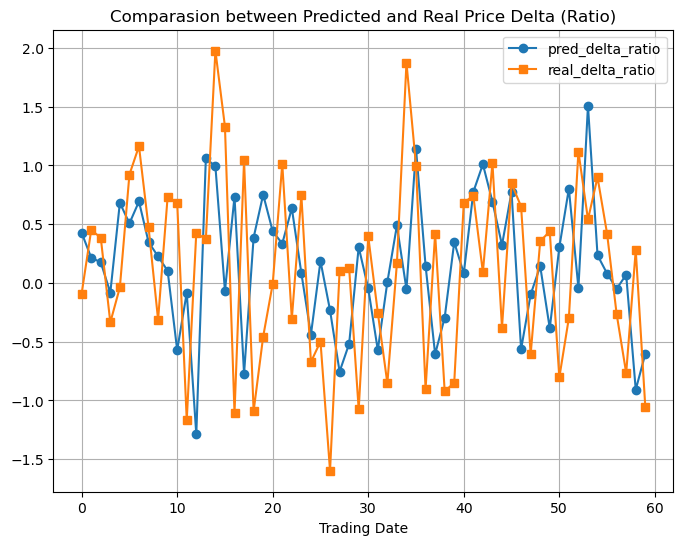

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the two series
plt.figure(figsize=(8, 6))
plt.plot(df_stats['AAPL']['pred_delta_ratio'][:60], label="pred_delta_ratio", marker='o')
plt.plot(df_stats['AAPL']['real_delta_ratio'][:60], label="real_delta_ratio", marker='s')

# Add labels, title, and legend
plt.xlabel("Trading Date")
plt.title("Comparasion between Predicted and Real Price Delta (Ratio)")
plt.legend()

plt.grid(True)
plt.show()

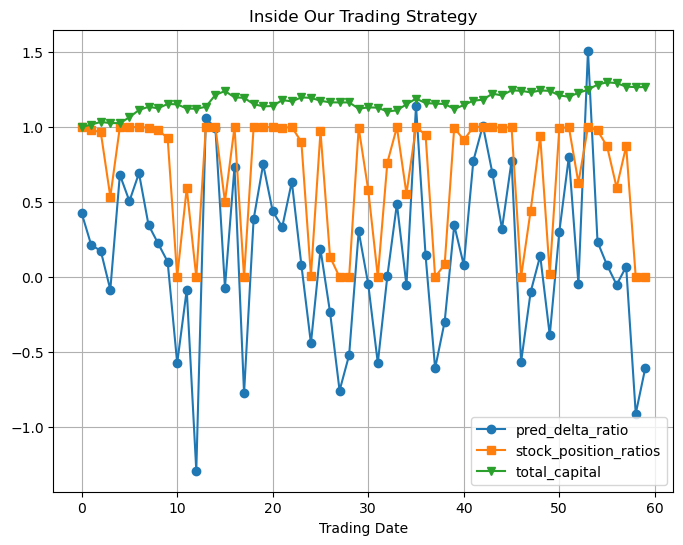

In [135]:
# Plot the two series
plt.figure(figsize=(8, 6))
plt.plot(df_stats['AAPL']['pred_delta_ratio'][:60], label="pred_delta_ratio", marker='o')
plt.plot(df_stats['AAPL']['ratios'][:60], label="stock_position_ratios", marker='s')
plt.plot(df_stats['AAPL']['capital'][:60] * 2 - 1, label="total_capital", marker='v')

# Add labels, title, and legend
plt.xlabel("Trading Date")
plt.title("Inside Our Trading Strategy")
plt.legend()

plt.grid(True)
plt.show()

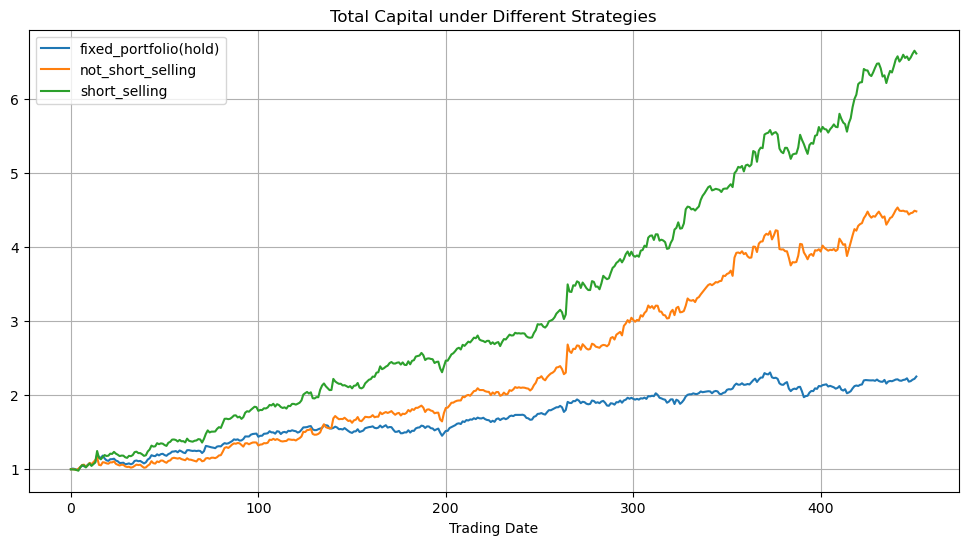

In [136]:
# Plot the two series
plt.figure(figsize=(12, 6))
plt.plot(df_trade5['capital'], label="fixed_portfolio(hold)")
plt.plot(df_portfolio['capital'], label="not_short_selling")
plt.plot(df_portfolio_short['capital'], label="short_selling")

# Add labels, title, and legend
plt.xlabel("Trading Date")
plt.title("Total Capital under Different Strategies")
plt.legend()

plt.grid(True)
plt.show()

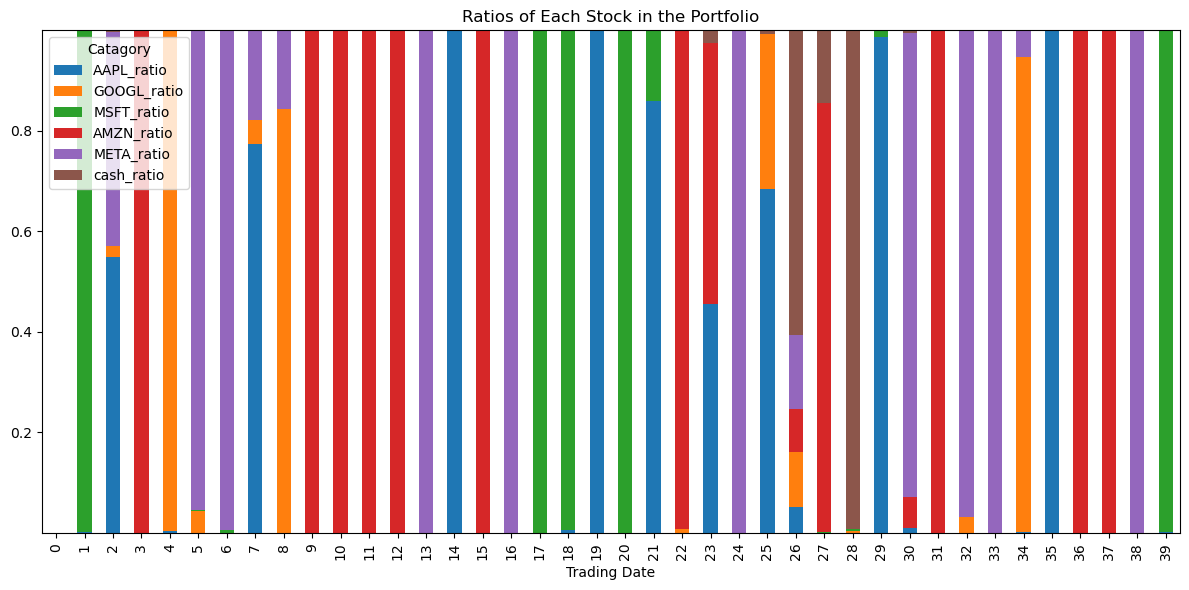

In [137]:
# Plot stacked bar chart
df_portfolio[['AAPL_ratio', 'GOOGL_ratio', 'MSFT_ratio', 'AMZN_ratio', 'META_ratio', 'cash_ratio']].head(40).plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.xlabel('Trading Date')
plt.title('Ratios of Each Stock in the Portfolio')
plt.legend(title='Catagory')
plt.tight_layout()  # Adjust layout for better appearance

# Show the plot
plt.show()